In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate

# Loading dataset

In [19]:
bs = 32
dataset_path = Path('../dataset')
print(dataset_path.ls())
lemon_names = get_image_files(dataset_path / 'lemon')
print(lemon_names[:5])

[PosixPath('../dataset/etrog'), PosixPath('../dataset/lemon'), PosixPath('../dataset/models')]
[PosixPath('../dataset/lemon/67. lemons-on-a-tree-58151d3a3df78cc2e88378d6.jpg'), PosixPath('../dataset/lemon/16. lemon-uses-0-1494115921.jpg'), PosixPath('../dataset/lemon/10. lemon_commodity-page.png'), PosixPath('../dataset/lemon/116. shaddo1b.jpg'), PosixPath('../dataset/lemon/121. 101840037.jpg')]


In [20]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(dataset_path, train='', valid_pct=0.2, ds_tfms=tfms, size=224, bs=bs).normalize(imagenet_stats)
print(data.classes)

['etrog', 'lemon']


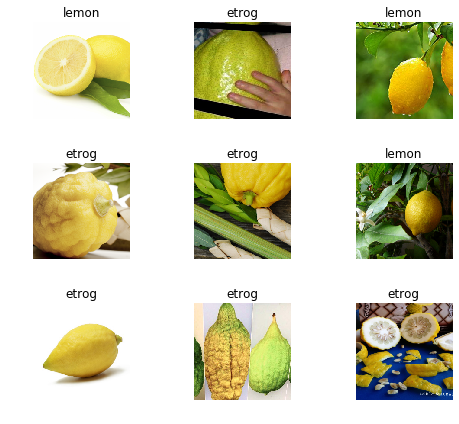

In [21]:
data.show_batch(rows=3, figsize=(7,6))

# Training

In [22]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn

Learner(data=ImageDataBunch;

Train: LabelList (211 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
etrog,etrog,etrog,etrog,etrog
Path: ../dataset;

Valid: LabelList (52 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
lemon,lemon,lemon,lemon,etrog
Path: ../dataset;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [23]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.698573,0.304297,0.134615,00:15
1,0.462594,0.236643,0.115385,00:14
2,0.369463,0.244567,0.096154,00:16
3,0.295192,0.248283,0.115385,00:15


In [26]:
learn.save('../../output_models/resnet_34_bs_32_size_224_stage_1.bin') # ../../ is a hack because default path is under dataset/models

# Results

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

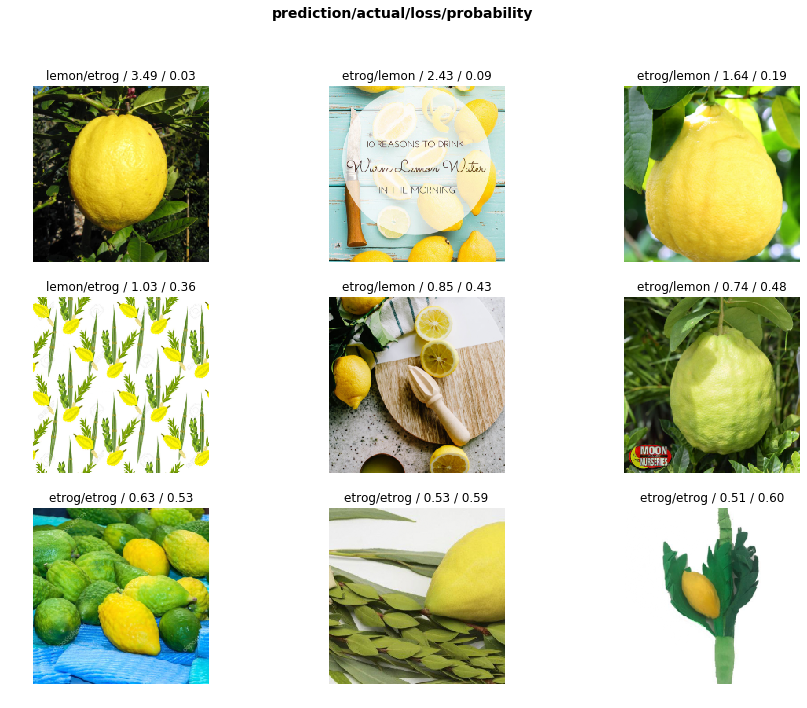

In [30]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=False)

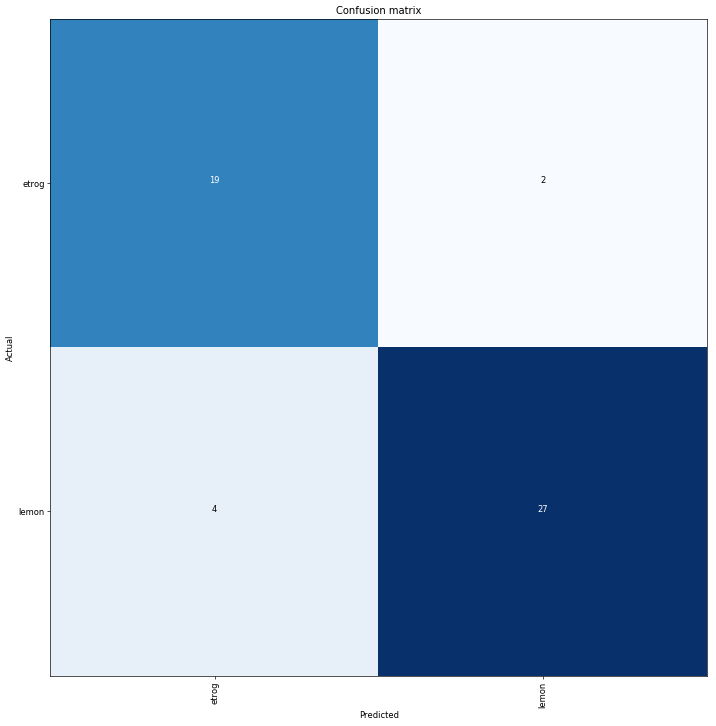

In [31]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [32]:
interp.most_confused(min_val=1)

[('lemon', 'etrog', 4), ('etrog', 'lemon', 2)]

# Learn with flip tranform

In [34]:
tfms_flip = get_transforms()
data_flip = ImageDataBunch.from_folder(dataset_path, train='', valid_pct=0.2, ds_tfms=tfms_flip, size=224, bs=bs).normalize(imagenet_stats)

In [35]:
learn_flip = cnn_learner(data_flip, models.resnet34, metrics=error_rate)
learn_flip.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.809490,0.334226,0.134615,00:13
1,0.553636,0.186704,0.115385,00:14
2,0.431259,0.210727,0.096154,00:14
3,0.348057,0.218963,0.057692,00:13


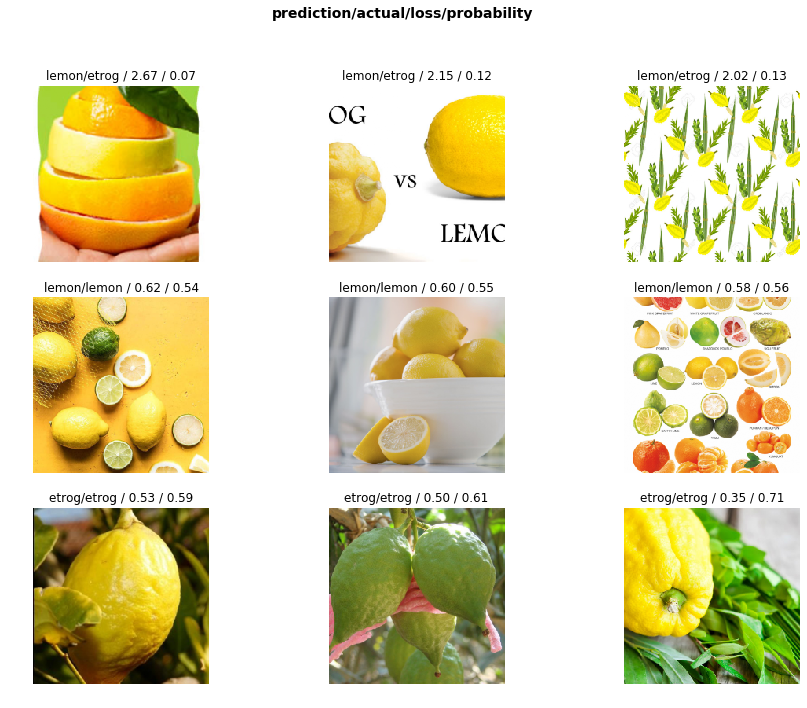

In [36]:
interp = ClassificationInterpretation.from_learner(learn_flip)
losses,idxs = interp.top_losses()
interp.plot_top_losses(9, figsize=(15,11), heatmap=False)

In [37]:
interp.most_confused(min_val=1)

[('etrog', 'lemon', 3)]

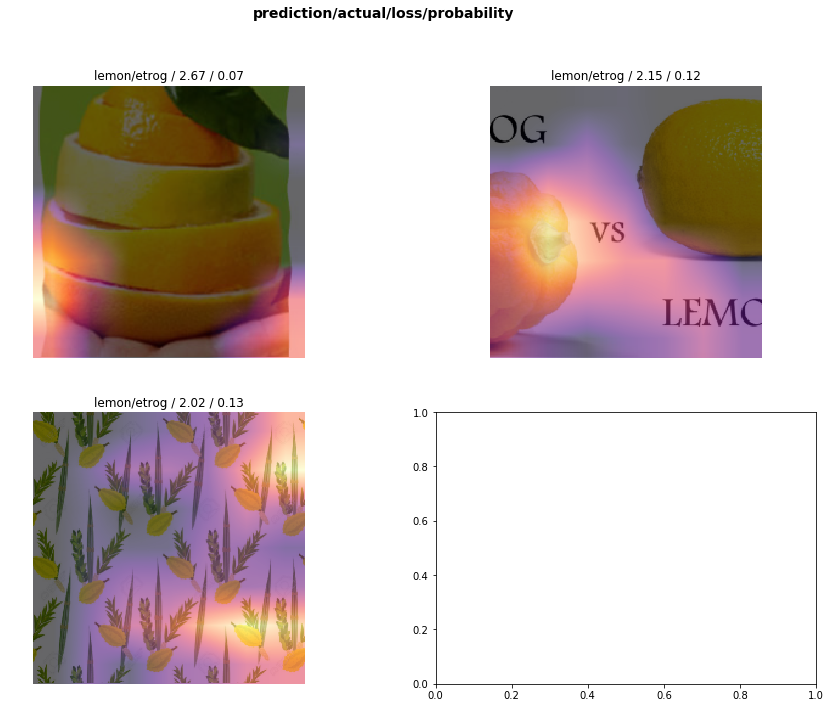

In [43]:
interp.plot_top_losses(3, figsize=(15,11))

In [50]:
learn_flip.save('../../output_models/resnet_34_bs_32_size_224_with_flip_tfs.bin')

## Unfreezing, fine-tuning, and learning rates

In [53]:
learn_flip.load('../../output_models/resnet_34_bs_32_size_224_with_flip_tfs.bin')
learn_flip.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


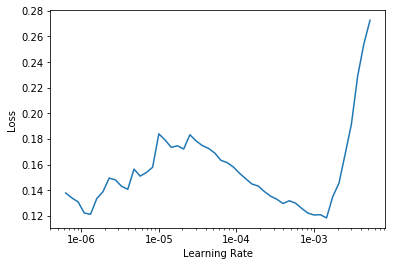

In [54]:
learn_flip.recorder.plot()

In [55]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.091993,0.415201,0.115385,00:16
1,0.097752,0.399508,0.134615,00:16
